In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_20 (Activation)   (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0638 - acc: 0.3529
Epoch 00001: val_loss improved from inf to 1.58022, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_3_conv_checkpoint/001-1.5802.hdf5
36805/36805 [==============================] - 107s 3ms/sample - loss: 2.0637 - acc: 0.3529 - val_loss: 1.5802 - val_acc: 0.5222
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4536 - acc: 0.5498
Epoch 00002: val_loss improved from 1.58022 to 1.43361, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_3_conv_checkpoint/002-1.4336.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.4535 - acc: 0.5499 - val_loss: 1.4336 - val_acc: 0.5616
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2374 - acc: 0.6176
Epoch 00003: val_loss improved from 1.43361 to 1.3541

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1624 - acc: 0.9490
Epoch 00028: val_loss did not improve from 1.27018
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.1623 - acc: 0.9491 - val_loss: 1.7071 - val_acc: 0.6571
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1520 - acc: 0.9536
Epoch 00029: val_loss did not improve from 1.27018
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.1521 - acc: 0.9535 - val_loss: 1.7172 - val_acc: 0.6608
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1548 - acc: 0.9520
Epoch 00030: val_loss did not improve from 1.27018
36805/36805 [==============================] - 106s 3ms/sample - loss: 0.1548 - acc: 0.9519 - val_loss: 1.7172 - val_acc: 0.6697
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1514 - acc: 0.9522
Epoch 00031: val_loss did not improve from 1.27018
36805/36805 [========

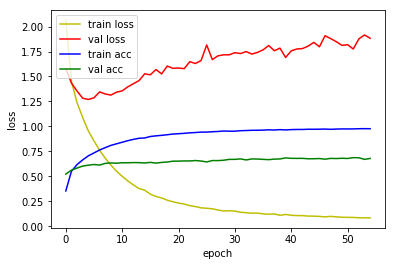

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.3620 - acc: 0.5755
Loss: 1.3620327086958681 Accuracy: 0.5754933

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0154 - acc: 0.3494
Epoch 00001: val_loss improved from inf to 1.51401, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_4_conv_checkpoint/001-1.5140.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 2.0154 - acc: 0.3494 - val_loss: 1.5140 - val_acc: 0.5253
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3993 - acc: 0.5606
Epoch 00002: val_loss improved from 1.51401 to 1.34496, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_4_conv_checkpoint/002-1.3450.hdf5
36805/36805 [==============================] - 112s 3ms/sample - loss: 1.3993 - acc: 0.5606 - val_loss: 1.3450 - val_acc: 0.5921
Epoch 3/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.2031 - acc: 0.9340
Epoch 00026: val_loss did not improve from 0.80985
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.2031 - acc: 0.9340 - val_loss: 0.8891 - val_acc: 0.7855
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2058 - acc: 0.9334
Epoch 00027: val_loss did not improve from 0.80985
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.2058 - acc: 0.9334 - val_loss: 0.9172 - val_acc: 0.7841
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1947 - acc: 0.9360
Epoch 00028: val_loss did not improve from 0.80985
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.1946 - acc: 0.9360 - val_loss: 0.8678 - val_acc: 0.7913
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1902 - acc: 0.9385
Epoch 00029: val_loss did not improve from 0.80985
36805/36805 [=====================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9654
Epoch 00056: val_loss did not improve from 0.80985
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.1106 - acc: 0.9654 - val_loss: 1.0180 - val_acc: 0.8025
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1068 - acc: 0.9664
Epoch 00057: val_loss did not improve from 0.80985
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.1068 - acc: 0.9664 - val_loss: 0.9937 - val_acc: 0.8076
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1057 - acc: 0.9667
Epoch 00058: val_loss did not improve from 0.80985
36805/36805 [==============================] - 112s 3ms/sample - loss: 0.1057 - acc: 0.9667 - val_loss: 0.9931 - val_acc: 0.8039
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9684
Epoch 00059: val_loss did not improve from 0.80985
36805/36805 [========

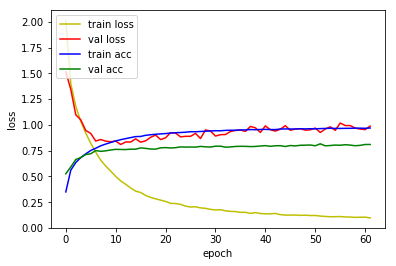

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.9251 - acc: 0.7371
Loss: 0.9251436805056634 Accuracy: 0.73707163

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0040 - acc: 0.3450
Epoch 00001: val_loss improved from inf to 1.43436, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_5_conv_checkpoint/001-1.4344.hdf5
36805/36805 [==============================] - 118s 3ms/sample - loss: 2.0039 - acc: 0.3450 - val_loss: 1.4344 - val_acc: 0.5539
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3547 - acc: 0.5701
Epoch 00002: val_loss improved from 1.43436 to 1.09884, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_5_conv_checkpoint/002-1.0988.hdf5
36805/36805 [==============================] - 117s 3ms/sample - loss: 1.3546 - acc: 0.5701 - val_loss: 1.0988 - val_acc: 0.6627
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2107 - acc: 0.9344
Epoch 00025: val_loss did not improve from 0.55074
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.2107 - acc: 0.9344 - val_loss: 0.5685 - val_acc: 0.8560
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2007 - acc: 0.9361
Epoch 00026: val_loss did not improve from 0.55074
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.2007 - acc: 0.9361 - val_loss: 0.7530 - val_acc: 0.8348
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1928 - acc: 0.9383
Epoch 00027: val_loss did not improve from 0.55074
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.1927 - acc: 0.9383 - val_loss: 0.6064 - val_acc: 0.8565
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1823 - acc: 0.9411
Epoch 00028: val_loss did not improve from 0.55074
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0984 - acc: 0.9684
Epoch 00055: val_loss did not improve from 0.55074
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0984 - acc: 0.9684 - val_loss: 0.6470 - val_acc: 0.8728
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0914 - acc: 0.9709
Epoch 00056: val_loss did not improve from 0.55074
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0914 - acc: 0.9709 - val_loss: 0.6293 - val_acc: 0.8644
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9691
Epoch 00057: val_loss did not improve from 0.55074
36805/36805 [==============================] - 116s 3ms/sample - loss: 0.0977 - acc: 0.9691 - val_loss: 0.6271 - val_acc: 0.8689
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9720
Epoch 00058: val_loss did not improve from 0.55074
36805/36805 [========

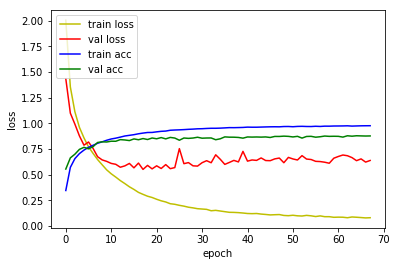

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6811 - acc: 0.8104
Loss: 0.6811446335951983 Accuracy: 0.8103842

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1591 - acc: 0.2885
Epoch 00001: val_loss improved from inf to 1.48551, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_6_conv_checkpoint/001-1.4855.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 2.1591 - acc: 0.2885 - val_loss: 1.4855 - val_acc: 0.5411
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4754 - acc: 0.5201
Epoch 00002: val_loss improved from 1.48551 to 1.21475, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_6_conv_checkpoint/002-1.2147.hdf5
36805/36805 [==============================] - 118s 3ms/sample - loss: 1.4753 - acc: 0.5201 - val_loss: 1.2147 - val_acc: 0.6331
Epoch 3/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.2567 - acc: 0.9190
Epoch 00024: val_loss did not improve from 0.31775
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.2567 - acc: 0.9190 - val_loss: 0.3241 - val_acc: 0.9159
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2469 - acc: 0.9226
Epoch 00025: val_loss improved from 0.31775 to 0.31453, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_6_conv_checkpoint/025-0.3145.hdf5
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.2469 - acc: 0.9226 - val_loss: 0.3145 - val_acc: 0.9175
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2356 - acc: 0.9268
Epoch 00026: val_loss improved from 0.31453 to 0.31084, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_6_conv_checkpoint/026-0.3108.hdf5
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.2356 - acc: 0.9268 - val_loss: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.1076 - acc: 0.9642
Epoch 00051: val_loss did not improve from 0.28556
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.1076 - acc: 0.9642 - val_loss: 0.3054 - val_acc: 0.9306
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9649
Epoch 00052: val_loss did not improve from 0.28556
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.1069 - acc: 0.9649 - val_loss: 0.3201 - val_acc: 0.9238
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9652
Epoch 00053: val_loss did not improve from 0.28556
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.1065 - acc: 0.9652 - val_loss: 0.3306 - val_acc: 0.9227
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1029 - acc: 0.9661
Epoch 00054: val_loss did not improve from 0.28556
36805/36805 [=====================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9800
Epoch 00081: val_loss did not improve from 0.28556
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0615 - acc: 0.9800 - val_loss: 0.3298 - val_acc: 0.9322
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9807
Epoch 00082: val_loss did not improve from 0.28556
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0607 - acc: 0.9807 - val_loss: 0.3329 - val_acc: 0.9355
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9798
Epoch 00083: val_loss did not improve from 0.28556
36805/36805 [==============================] - 117s 3ms/sample - loss: 0.0606 - acc: 0.9798 - val_loss: 0.3545 - val_acc: 0.9331
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9788
Epoch 00084: val_loss did not improve from 0.28556
36805/36805 [========

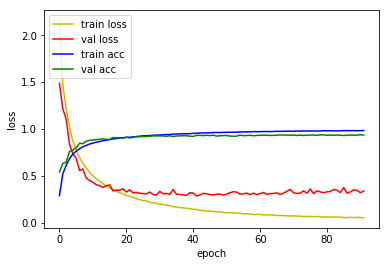

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3464 - acc: 0.9067
Loss: 0.3463953990678797 Accuracy: 0.9067497

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2630 - acc: 0.2517
Epoch 00001: val_loss improved from inf to 1.49391, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_7_conv_checkpoint/001-1.4939.hdf5
36805/36805 [==============================] - 122s 3ms/sample - loss: 2.2629 - acc: 0.2517 - val_loss: 1.4939 - val_acc: 0.5192
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5172 - acc: 0.4947
Epoch 00002: val_loss improved from 1.49391 to 1.17407, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_7_conv_checkpoint/002-1.1741.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 1.5171 - acc: 0.4947 - val_loss: 1.1741 - val_acc: 0.6392
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1975 - acc: 0.9372
Epoch 00023: val_loss improved from 0.16493 to 0.15783, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_7_conv_checkpoint/023-0.1578.hdf5
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.1976 - acc: 0.9372 - val_loss: 0.1578 - val_acc: 0.9550
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1901 - acc: 0.9388
Epoch 00024: val_loss did not improve from 0.15783
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.1901 - acc: 0.9388 - val_loss: 0.1594 - val_acc: 0.9550
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1846 - acc: 0.9402
Epoch 00025: val_loss did not improve from 0.15783
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.1846 - acc: 0.9402 - val_loss: 0.1652 - val_acc: 0.9548
Epoch 26/500
36800/36805 [============================>.] - ETA: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9720
Epoch 00051: val_loss did not improve from 0.13799
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0834 - acc: 0.9720 - val_loss: 0.1640 - val_acc: 0.9588
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9719
Epoch 00052: val_loss did not improve from 0.13799
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0848 - acc: 0.9719 - val_loss: 0.1474 - val_acc: 0.9667
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0776 - acc: 0.9749
Epoch 00053: val_loss did not improve from 0.13799
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0775 - acc: 0.9749 - val_loss: 0.1702 - val_acc: 0.9616
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0789 - acc: 0.9735
Epoch 00054: val_loss did not improve from 0.13799
36805/36805 [=====================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0447 - acc: 0.9845
Epoch 00081: val_loss did not improve from 0.13799
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0447 - acc: 0.9845 - val_loss: 0.1591 - val_acc: 0.9644
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9856
Epoch 00082: val_loss did not improve from 0.13799
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0441 - acc: 0.9856 - val_loss: 0.1677 - val_acc: 0.9660
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9847
Epoch 00083: val_loss did not improve from 0.13799
36805/36805 [==============================] - 118s 3ms/sample - loss: 0.0453 - acc: 0.9847 - val_loss: 0.1556 - val_acc: 0.9634
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9860
Epoch 00084: val_loss did not improve from 0.13799
36805/36805 [========

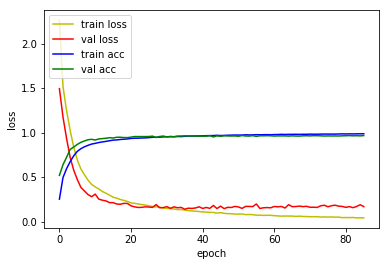

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1737 - acc: 0.9508
Loss: 0.1737203850305464 Accuracy: 0.95077884

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1899 - acc: 0.2811
Epoch 00001: val_loss improved from inf to 1.30519, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_8_conv_checkpoint/001-1.3052.hdf5
36805/36805 [==============================] - 124s 3ms/sample - loss: 2.1898 - acc: 0.2812 - val_loss: 1.3052 - val_acc: 0.5977
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3064 - acc: 0.5710
Epoch 00002: val_loss improved from 1.30519 to 0.80767, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_8_conv_checkpoint/002-0.8077.hdf5
36805/36805 [==============================] - 120s 3ms/sample - loss: 1.3064 - acc: 0.5710 - val_loss: 0.8077 - val_acc: 0.7603
Epoch 3/500
36800/36805 [============================>.] - ETA

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1372 - acc: 0.9556  ETA: 11s 
Epoch 00025: val_loss did not improve from 0.10646
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.1372 - acc: 0.9556 - val_loss: 0.1173 - val_acc: 0.9630
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1276 - acc: 0.9598
Epoch 00026: val_loss did not improve from 0.10646
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.1276 - acc: 0.9598 - val_loss: 0.1070 - val_acc: 0.9665
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1257 - acc: 0.9589
Epoch 00027: val_loss did not improve from 0.10646
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.1257 - acc: 0.9589 - val_loss: 0.1179 - val_acc: 0.9648
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1182 - acc: 0.9616
Epoch 00028: val_loss did not improve from 0.10646
36805/3680

36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9836- ETA: 4s - loss
Epoch 00053: val_loss did not improve from 0.08727
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0496 - acc: 0.9836 - val_loss: 0.1150 - val_acc: 0.9681
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9828
Epoch 00054: val_loss did not improve from 0.08727
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0517 - acc: 0.9828 - val_loss: 0.1051 - val_acc: 0.9720
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9828
Epoch 00055: val_loss did not improve from 0.08727
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0496 - acc: 0.9828 - val_loss: 0.1032 - val_acc: 0.9741
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9838
Epoch 00056: val_loss did not improve from 0.08727
36805/36805 [=====

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9911
Epoch 00083: val_loss did not improve from 0.08727
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0258 - acc: 0.9911 - val_loss: 0.1452 - val_acc: 0.9711
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9923
Epoch 00084: val_loss did not improve from 0.08727
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0256 - acc: 0.9923 - val_loss: 0.1469 - val_acc: 0.9679
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9914
Epoch 00085: val_loss did not improve from 0.08727
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0261 - acc: 0.9914 - val_loss: 0.1283 - val_acc: 0.9700
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9916
Epoch 00086: val_loss did not improve from 0.08727
36805/36805 [========

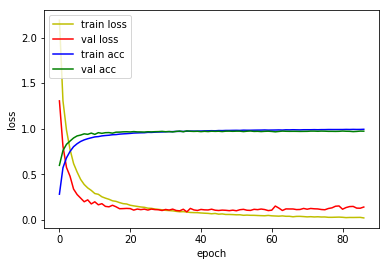

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1344 - acc: 0.9610
Loss: 0.1344477171204048 Accuracy: 0.9609553

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8336 - acc: 0.3963
Epoch 00001: val_loss improved from inf to 0.85812, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_9_conv_checkpoint/001-0.8581.hdf5
36805/36805 [==============================] - 125s 3ms/sample - loss: 1.8336 - acc: 0.3963 - val_loss: 0.8581 - val_acc: 0.7289
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8779 - acc: 0.7151
Epoch 00002: val_loss improved from 0.85812 to 0.60062, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_9_conv_checkpoint/002-0.6006.hdf5
36805/36805 [==============================] - 121s 3ms/sample - loss: 0.8779 - acc: 0.7151 - val_loss: 0.6006 - val_acc: 0.8083
Epoch 3/500
36800/36805 [============================>.] - ETA:

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0767 - acc: 0.9748
Epoch 00025: val_loss did not improve from 0.09367
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.0767 - acc: 0.9748 - val_loss: 0.1204 - val_acc: 0.9662
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0706 - acc: 0.9768
Epoch 00026: val_loss did not improve from 0.09367
36805/36805 [==============================] - 120s 3ms/sample - loss: 0.0706 - acc: 0.9768 - val_loss: 0.1201 - val_acc: 0.9681
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9786
Epoch 00027: val_loss did not improve from 0.09367
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0636 - acc: 0.9786 - val_loss: 0.1146 - val_acc: 0.9693
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9802
Epoch 00028: val_loss did not improve from 0.09367
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0246 - acc: 0.9921
Epoch 00054: val_loss did not improve from 0.09300
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0246 - acc: 0.9921 - val_loss: 0.1284 - val_acc: 0.9688
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9930
Epoch 00055: val_loss did not improve from 0.09300
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0213 - acc: 0.9930 - val_loss: 0.1358 - val_acc: 0.9718
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9932
Epoch 00056: val_loss did not improve from 0.09300
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0218 - acc: 0.9932 - val_loss: 0.1536 - val_acc: 0.9704
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9922
Epoch 00057: val_loss did not improve from 0.09300
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0155 - acc: 0.9952
Epoch 00084: val_loss did not improve from 0.09300
36805/36805 [==============================] - 119s 3ms/sample - loss: 0.0155 - acc: 0.9952 - val_loss: 0.1313 - val_acc: 0.9727

1D_CNN_custom_ch_128_DO_075_DO_9_conv Model


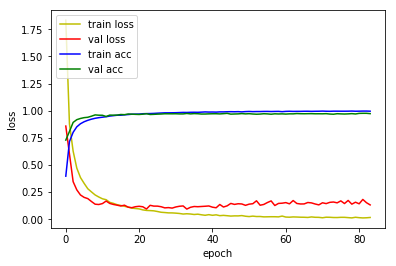

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1569 - acc: 0.9570
Loss: 0.15691328315714206 Accuracy: 0.9570094



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO_075_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)

#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_44 (Activation)   (N

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3464 - acc: 0.9067
Loss: 0.3463953990678797 Accuracy: 0.9067497

1D_CNN_custom_ch_128_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_62 (Conv1D)           (

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1569 - acc: 0.9570
Loss: 0.15691328315714206 Accuracy: 0.9570094


In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_128_DO_075_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_44 (Activation)   (N

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3846 - acc: 0.9130
Loss: 0.38458654764045497 Accuracy: 0.91298026

1D_CNN_custom_ch_128_DO_075_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_62 (Conv1D)          

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.1983 - acc: 0.9645
Loss: 0.19834257886027082 Accuracy: 0.964486
